In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import os
import requests
import sys

import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jupyter/atomsci/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.
DEBUG:ATOM:Model tracker client not supported in your environment; will save models in filesystem only.


In [2]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

--2023-06-14 15:12:58--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh’

install_AMPL_GPU_te 100%[===================>]   1.10K  --.-KB/s    in 0s      

2023-06-14 15:12:58 (48.5 MB/s) - ‘install_AMPL_GPU_test.sh’ saved [1127/1127]

Cloning into 'AMPL'...
remote: Enumerating objects: 8236, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 8236 (delta 103), reused 136 (delta 69), pack-reused 8040
Receiving objects: 100% (8236/8236), 114.50 MiB | 32.48 MiB/s, done.
Resolving deltas: 100% (5144/5144), done.
error: pathspec 'deepchem_25

In [3]:
#Define Target Name
target_name='QM9_Dataset'

In [6]:
#Download Dataset
import io
url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv'
download = requests.get(url).content

In [7]:
#To pandas df
orig_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

In [8]:
orig_df.head(3)

mol_id smiles          A          B          C      mu  alpha    homo  \
0  gdb_1      C  157.71180  157.70997  157.70699  0.0000  13.21 -0.3877   
1  gdb_2      N  293.60975  293.54111  191.39397  1.6256   9.46 -0.2570   
2  gdb_3      O  799.58812  437.90386  282.94545  1.8511   6.31 -0.2928   

     lumo     gap  ...      zpve         u0       u298       h298       g298  \
0  0.1171  0.5048  ...  0.044749 -40.478930 -40.476062 -40.475117 -40.498597   
1  0.0829  0.3399  ...  0.034358 -56.525887 -56.523026 -56.522082 -56.544961   
2  0.0687  0.3615  ...  0.021375 -76.404702 -76.401867 -76.400922 -76.422349   

      cv     u0_atom   u298_atom   h298_atom   g298_atom  
0  6.469 -395.999595 -398.643290 -401.014647 -372.471772  
1  6.316 -276.861363 -278.620271 -280.399259 -259.338802  
2  6.002 -213.087624 -213.974294 -215.159658 -201.407171  

[3 rows x 21 columns]

In [9]:
orig_df.describe()

A              B              C             mu  \
count  133885.000000  133885.000000  133885.000000  133885.000000   
mean        9.814382       1.406097       1.124921       2.706037   
std      1809.465666       1.583795       1.095618       1.530394   
min         0.000000       0.337120       0.331180       0.000000   
25%         2.554430       1.091630       0.910480       1.588700   
50%         3.090360       1.369940       1.078560       2.500000   
75%         3.835820       1.653980       1.279540       3.636100   
max    619867.683140     437.903860     282.945450      29.556400   

               alpha           homo           lumo            gap  \
count  133885.000000  133885.000000  133885.000000  133885.000000   
mean       75.191296      -0.239977       0.011124       0.251100   
std         8.187793       0.022131       0.046936       0.047519   
min         6.310000      -0.428600      -0.175000       0.024600   
25%        70.380000      -0.252500      -0.023800       0.216300   
50%        75.500000      -0.241000       0.012000       0.249400   
75%        80.520000      -0.228700       0.049200       0.288200   
max       196.620000      -0.101700       0.193500       0.622100   

                  r2           zpve             u0           u298  \
count  133885.000000  133885.000000  133885.000000  133885.000000   
mean     1189.527450       0.148524    -411.543985    -411.535513   
std       279.757172       0.033274      40.060230      40.060012   
min        19.000200       0.015951    -714.568061    -714.560153   
25%      1018.322600       0.125289    -437.913936    -437.905942   
50%      1147.585800       0.148329    -417.864758    -417.857351   
75%      1308.816600       0.171150    -387.049166    -387.039746   
max      3374.753200       0.273944     -40.478930     -40.476062   

                h298           g298             cv        u0_atom  \
count  133885.000000  133885.000000  133885.000000  133885.000000   
mean     -411.534569    -411.577397      31.600676   -1750.812997   
std        40.060012      40.060741       4.062471     239.313373   
min      -714.559209    -714.602138       6.002000   -2608.448864   
25%      -437.904997    -437.947682      28.942000   -1904.772194   
50%      -417.856407    -417.895731      31.555000   -1753.464714   
75%      -387.038802    -387.083279      34.276000   -1596.871098   
max       -40.475117     -40.498597      46.969000    -213.087624   

           u298_atom      h298_atom      g298_atom  
count  133885.000000  133885.000000  133885.000000  
mean    -1761.480647   -1771.546928   -1629.388196  
std       241.436103     243.151065     220.207088  
min     -2626.408172   -2643.007040   -2417.121997  
25%     -1916.981009   -1928.181417   -1771.350603  
50%     -1764.090324   -1774.151176   -1632.224955  
75%     -1606.108658   -1615.066349   -1488.291333  
max      -213.974294    -215.159658    -201.407171

In [10]:
orig_df.gap.value_counts()

0.2203    161
0.2228    161
0.2208    156
0.2213    155
0.2162    148
         ... 
0.1230      1
0.1371      1
0.0955      1
0.1294      1
0.0823      1
Name: gap, Length: 2705, dtype: int64

In [11]:
#create ofile
ofile=target_name+'_excape.csv'

In [12]:
print(orig_df.shape)
display(orig_df.columns)

(133885, 21)


Index(['mol_id', 'smiles', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap',
       'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom',
       'u298_atom', 'h298_atom', 'g298_atom'],
      dtype='object')

In [13]:
#Fill in any missing values
save_df=orig_df
save_df['gap'] = save_df['gap'].fillna(0)

In [14]:
import atomsci.ddm.pipeline.diversity_plots as dp

In [ ]:
save_df['rdkit_smiles'] = save_df['smiles'].apply(curate_data.base_smiles_from_smiles)

save_df['inchi_key'] = save_df['smiles'].apply(struct_utils.smiles_to_inchi_key)

[15:18:40] Can't kekulize mol.  Unkekulized atoms: 2 6
[15:18:40] Can't kekulize mol.  Unkekulized atoms: 3 5
[15:18:40] Can't kekulize mol.  Unkekulized atoms: 3 7
[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Proton(s) added/removed

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:30] WARNING: Omitted undefined stereo

[15:21:3

In [16]:
save_smiles_df = save_df
save_smiles_df['compound_id'] = save_smiles_df['inchi_key']
save_smiles_df.head(8)

mol_id smiles          A           B           C      mu  alpha    homo  \
0  gdb_1      C  157.71180  157.709970  157.706990  0.0000  13.21 -0.3877   
1  gdb_2      N  293.60975  293.541110  191.393970  1.6256   9.46 -0.2570   
2  gdb_3      O  799.58812  437.903860  282.945450  1.8511   6.31 -0.2928   
3  gdb_4    C#C    0.00000   35.610036   35.610036  0.0000  16.28 -0.2845   
4  gdb_5    C#N    0.00000   44.593883   44.593883  2.8937  12.99 -0.3604   
5  gdb_6    C=O  285.48839   38.982300   34.298920  2.1089  14.18 -0.2670   
6  gdb_7     CC   80.46225   19.906490   19.906330  0.0000  23.95 -0.3385   
7  gdb_8     CO  127.83497   24.858720   23.978720  1.5258  16.97 -0.2653   

     lumo     gap  ...        h298        g298      cv     u0_atom  \
0  0.1171  0.5048  ...  -40.475117  -40.498597   6.469 -395.999595   
1  0.0829  0.3399  ...  -56.522082  -56.544961   6.316 -276.861363   
2  0.0687  0.3615  ...  -76.400922  -76.422349   6.002 -213.087624   
3  0.0506  0.3351  ...  -77.304583  -77.327429   8.574 -385.501997   
4  0.0191  0.3796  ...  -93.408425  -93.431246   6.278 -301.820534   
5 -0.0406  0.2263  ... -114.479802 -114.505268   6.413 -358.756935   
6  0.1041  0.4426  ...  -79.759722  -79.787269  10.098 -670.788296   
7  0.0784  0.3437  ... -115.674872 -115.701876   8.751 -481.106758   

    u298_atom   h298_atom   g298_atom  rdkit_smiles  \
0 -398.643290 -401.014647 -372.471772             C   
1 -278.620271 -280.399259 -259.338802             N   
2 -213.974294 -215.159658 -201.407171             O   
3 -387.237686 -389.016047 -365.800724           C#C   
4 -302.906752 -304.091489 -288.720028           C#N   
5 -360.512706 -362.291066 -340.464421           C=O   
6 -675.710476 -679.860821 -626.927299            CC   
7 -484.355372 -487.319724 -450.124128            CO   

                     inchi_key                  compound_id  
0  VNWKTOKETHGBQD-UHFFFAOYSA-N  VNWKTOKETHGBQD-UHFFFAOYSA-N  
1  QGZKDVFQNNGYKY-UHFFFAOYSA-N  QGZKDVFQNNGYKY-UHFFFAOYSA-N  
2  XLYOFNOQVPJJNP-UHFFFAOYSA-N  XLYOFNOQVPJJNP-UHFFFAOYSA-N  
3  HSFWRNGVRCDJHI-UHFFFAOYSA-N  HSFWRNGVRCDJHI-UHFFFAOYSA-N  
4  LELOWRISYMNNSU-UHFFFAOYSA-N  LELOWRISYMNNSU-UHFFFAOYSA-N  
5  WSFSSNUMVMOOMR-UHFFFAOYSA-N  WSFSSNUMVMOOMR-UHFFFAOYSA-N  
6  OTMSDBZUPAUEDD-UHFFFAOYSA-N  OTMSDBZUPAUEDD-UHFFFAOYSA-N  
7  OKKJLVBELUTLKV-UHFFFAOYSA-N  OKKJLVBELUTLKV-UHFFFAOYSA-N  

[8 rows x 24 columns]

In [17]:
print(save_smiles_df.shape)
save_smiles_df.head(3)


(133885, 24)


mol_id smiles          A          B          C      mu  alpha    homo  \
0  gdb_1      C  157.71180  157.70997  157.70699  0.0000  13.21 -0.3877   
1  gdb_2      N  293.60975  293.54111  191.39397  1.6256   9.46 -0.2570   
2  gdb_3      O  799.58812  437.90386  282.94545  1.8511   6.31 -0.2928   

     lumo     gap  ...       h298       g298     cv     u0_atom   u298_atom  \
0  0.1171  0.5048  ... -40.475117 -40.498597  6.469 -395.999595 -398.643290   
1  0.0829  0.3399  ... -56.522082 -56.544961  6.316 -276.861363 -278.620271   
2  0.0687  0.3615  ... -76.400922 -76.422349  6.002 -213.087624 -213.974294   

    h298_atom   g298_atom  rdkit_smiles                    inchi_key  \
0 -401.014647 -372.471772             C  VNWKTOKETHGBQD-UHFFFAOYSA-N   
1 -280.399259 -259.338802             N  QGZKDVFQNNGYKY-UHFFFAOYSA-N   
2 -215.159658 -201.407171             O  XLYOFNOQVPJJNP-UHFFFAOYSA-N   

                   compound_id  
0  VNWKTOKETHGBQD-UHFFFAOYSA-N  
1  QGZKDVFQNNGYKY-UHFFFAOYSA-N  
2  XLYOFNOQVPJJNP-UHFFFAOYSA-N  

[3 rows x 24 columns]

Post-processing dataset

Total Number of results = 133885
dataset mean = 0.25110037121410167 eV
dataset stdev = 0.047518887870584905 eV
dataset max = 0.6221 eV
dataset min = 0.0246 eV



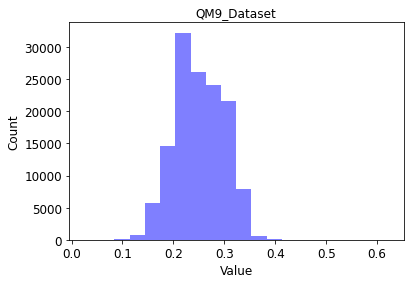

In [19]:
# Our outcome is gap 
column = 'gap'

# num_bins wil decide how many bins for creating histogram plot
num_bins = 20

# Ue the target_name as the title for the plot 
title = target_name

# Outcome data units (nanomolar = nm = $1 x 10^-9$ M )
units = 'eV'

# filepath, in this case, current dir
filepath = ""

# save_smiles_df was defined earlier
data=save_smiles_df

# call AMPL function (mouse over the function call and view source to see the code)
# The curate_data.summarize_data will summarize the data 
# output will be: 
# Total Number of results (data rows)
#   dataset mean: (mean of pXC50)
#   dataset stdev: (sd of pXC50)
#   dataset max: max value of data
#   dataset min: min value of data
curate_data.summarize_data(column, num_bins, title, units, filepath, data)

In [20]:
print(data.columns)
print(ofile)

Index(['mol_id', 'smiles', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap',
       'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom',
       'u298_atom', 'h298_atom', 'g298_atom', 'rdkit_smiles', 'inchi_key',
       'compound_id'],
      dtype='object')
QM9_Dataset_excape.csv


In [21]:
curated_file = ofile

In [22]:
# column: Response values column
column = 'gap'

# tolerance: Percentage of individual respsonse values allowed to differ from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response 
# value. 
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# column that will be averaged ; smiles_col; used to find the replicates

In [23]:
unique_smiles = data.groupby(smiles_col)
VALUE_NUM_mean = unique_smiles[column].mean()
VALUE_NUM_std = unique_smiles[column].std()

In [25]:
data.columns

Index(['mol_id', 'smiles', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap',
       'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom',
       'u298_atom', 'h298_atom', 'g298_atom', 'rdkit_smiles', 'inchi_key',
       'compound_id'],
      dtype='object')

In [26]:
print(unique_smiles)

In [27]:
print(VALUE_NUM_mean)

rdkit_smiles
C               0.5048
C#C             0.3351
C#CC            0.3222
C#CC#C          0.2386
C#CC#CC         0.2335
                 ...  
n1nc2nnoc2o1    0.1794
n1nc2nonc2o1    0.1791
n1nc2onnc2o1    0.1774
n1nc2onnn2n1    0.2119
n1nnon1         0.2598
Name: gap, Length: 133787, dtype: float64


In [28]:
curated_df = curate_data.average_and_remove_duplicates(column, 
                                                       tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)
# curated_file = os.path.join(working_dir, ofile)
## discard out of range values
curated_df=curated_df[curated_df['VALUE_NUM_mean']>-1]
curated_df.to_csv(curated_file, index=False)

Bad duplicates removed from dataset
Dataframe size (133885, 28)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, gap, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (133787, 28)
New column created with averaged values:  VALUE_NUM_mean


In [29]:
curated_df['Remove_BadDuplicate'].value_counts()

0    133787
Name: Remove_BadDuplicate, dtype: int64

In [30]:
compound_id='rdkit_smiles'
reject=data[~data[compound_id].isin(curated_df[compound_id])]
reject

Empty DataFrame
Columns: [mol_id, smiles, A, B, C, mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv, u0_atom, u298_atom, h298_atom, g298_atom, rdkit_smiles, inchi_key, compound_id]
Index: []

[0 rows x 24 columns]

In [31]:
print("Number of discarded compounds",reject[compound_id].nunique())
ofile=target_name+'.reject_check.csv'
reject.to_csv(ofile,index=False)

Number of discarded compounds 0


(0.0, 12.0)

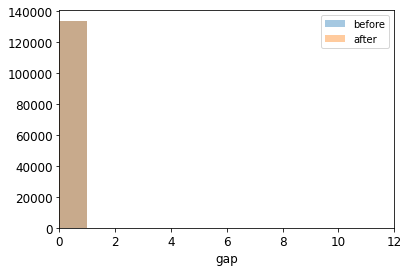

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()

# This will be our before curation
before=data["gap"]

# current curated dataframe will not include any out of range values
after=curated_df["gap"]

sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')
plt.legend()
ax.set_xlim([0, 12])

In [3]:
ifile='_excape.csv'

In [4]:
x_del = pd.read_csv(ifile)

FileNotFoundError: [Errno 2] No such file or directory: '_excape.csv'

In [2]:
x_del.columns

NameError: name 'x_del' is not defined

In [36]:
dp.diversity_plots(dset_key=ifile,datastore=False,id_col='inchi_key',response_col='gap')

KeyError: 'InChI'

In [ ]:
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd


In [ ]:


feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = save_smiles_df['rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)